In [1]:
import sys
sys.path.append("../")

In [15]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.mmd.mmd import MMD
from src.ksd.kernel import IMQ, RBF, Linear
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns

import src.kgof.density as density
import src.kgof.data as data

MCMCKernel = RandomWalkMH # RandomWalkBarker

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
tf.random.set_seed(1)

DELTA = 2.

In [4]:
# normal
def generate_target_proposal(dim, delta=DELTA):
    # single gaussians
    
    mean1 = tf.eye(dim)[:, 0] * delta
    mean2 = tf.zeros(dim)

    target = tfd.MultivariateNormalDiag(mean1)
    proposal_off = tfd.MultivariateNormalDiag(mean2)
    
    return target, proposal_off

In [5]:
# # laplace
# def generate_target_proposal(dim, delta=DELTA):
#     # single gaussians
    
#     mean1 = tf.eye(dim)[:, 0] * delta
#     mean2 = tf.zeros(dim)

#     target = tfd.Laplace(mean1, scale=1.)
#     proposal_off = tfd.Laplace(mean2, scale=1.)
    
#     return target, proposal_off

In [6]:
# # t
# def generate_target_proposal(dim, delta=DELTA):
#     # single gaussians
    
#     mean1 = tf.eye(dim)[:, 0] * delta
#     mean2 = tf.zeros(dim)

#     target = tfd.StudentT(df=5, loc=mean1, scale=1.)
#     proposal_off = tfd.StudentT(df=5, loc=mean2, scale=1.)
    
#     return target, proposal_off

2023-01-28 17:02:09.276631: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-28 17:02:09.276674: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nvidia4
2023-01-28 17:02:09.276681: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nvidia4
2023-01-28 17:02:09.276795: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2023-01-28 17:02:09.276819: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2023-01-28 17:02:09.276825: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2023-01-28 17:02:09.278100: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

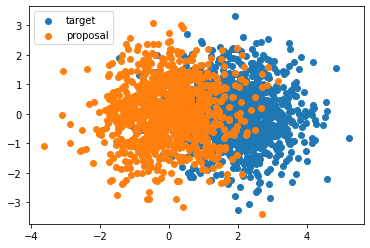

In [7]:
target, proposal = generate_target_proposal(2)
target_x = target.sample(1000)
proposal_x = proposal.sample(1000)

fig, ax = plt.subplots()
ax.scatter(target_x[:, 0], target_x[:, 1], label="target")
ax.scatter(proposal_x[:, 0], proposal_x[:, 1], label="proposal")
ax.legend()
plt.show()

In [8]:
def plot_bandwidth(dims, kernel_class, n):
    
    bandwidths = []
    for d in dims:
        print(f"dim {d}")
        _, proposal_dist = generate_target_proposal(d)
        X = proposal_dist.sample(n)
        
        kernel = kernel_class(med_heuristic=True)
        kernel.bandwidth(X, tf.identity(X))
        bandwidths.append(kernel.sigma_sq)
        
    # plot
    fig, ax = plt.subplots()
    ax.plot(dims, bandwidths, label="empirical")
    ax.plot(dims, 2 * np.array(dims), label="theoretical")
    ax.set_ylabel("Bandwidth")
    ax.set_xlabel("Dim")
    ax.legend()
    plt.show()
    
    return bandwidths

In [9]:
dims = [1, 2, 5, 10, 20, 30, 40, 50, 100]

dim 1
dim 2
dim 5
dim 10
dim 20
dim 30
dim 40
dim 50
dim 100


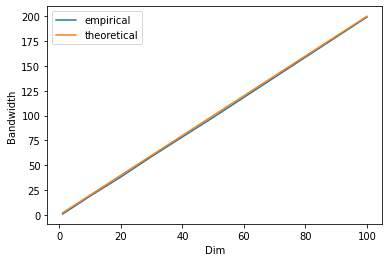

In [10]:
tf.random.set_seed(1)
bandwidths = plot_bandwidth(dims, RBF, n=1000)

In [11]:
class MMDAnalytical:
    def __init__(self, dim, mu_norm, bandwidth_power):
        self.d = dim
        self.mu_norm_sq = mu_norm**2
        self.r = bandwidth_power
        self.lmda = self.d**self.r
        
    def mmd(self):
        res = 2 * (self.lmda / (2 + self.lmda))**(self.d / 2) * (
            1 - tf.exp(- 1 / (2 * (2 + self.lmda)) * self.mu_norm_sq)
        )
        
#         res = 2 * (self.lmda / (1 + self.lmda))**(self.d / 2) * (
#             1 - tf.exp(- 1 / (4 * (1 + self.lmda)) * self.mu_norm_sq)
#         )
        return res

    def m2_ub(self):
        res = 8 * (self.lmda / (3 + self.lmda))**(self.d / 2) * (
            self.lmda / (1 + self.lmda)
        )**(self.d / 2) * (
            1 + tf.exp(- 1 / (3 + self.lmda) * self.mu_norm_sq)
        )
        return res
    
    def cond_var(self):
        return self.m2_ub() - self.mmd()**2
        
    def M2(self):
        term1 = 2 * (self.lmda / (4 + self.lmda))**(self.d / 2) * (
            1 + tf.exp( - 1 / (4 + self.lmda) * self.mu_norm_sq )
        )
        term2 = 2 * (self.lmda / (2 + self.lmda))**self.d
        term3 = - 8 * (self.lmda / (3 + self.lmda))**(self.d / 2) * (
            self.lmda / (1 + self.lmda)
        )**(self.d / 2) * tf.exp(
            - (2 + self.lmda) / (2 * (1 + self.lmda) * (3 + self.lmda)) * self.mu_norm_sq
        )
        term4 = 2 * (self.lmda / (2 + self.lmda))**self.d * tf.exp(
            - 1 / (2 + self.lmda) * self.mu_norm_sq
        )
        return term1 + term2 + term3 + term4
    
    def full_var(self):
        return self.M2() - self.mmd()**2
    
    def abs_cond_moment_ub(self, nu):
        """
        Upper bound for *non-central* absolute conditional moments.
        """
        res = 2**(2*nu - 1) * (
            nu / (1 + nu + self.lmda)
        )**(self.d / 2) * (
            1 + tf.exp(- nu / (2 * (1 + nu + self.lmda)) * self.mu_norm_sq)
        )
        return res
    
    def abs_full_moment_ub(self, nu):
        """
        Upper bound for *non-central* absolute full moments.
        """
        res = 2**(2*nu - 1) * (
            self.lmda / (2*nu + self.lmda)
        )**(self.d / 2) * (
            1 + tf.exp(- nu / (2 * (2 * nu + self.lmda)) * self.mu_norm_sq)
        )
        return res

In [12]:
# def compute_moments_theoretical(dims, deltas, kernel_class, bandwidth_order, verbose=False):

#     dims_output = []
#     deltas_output = []

#     val_empirical_list = []
#     val_theoretical_list = []
#     cond_var_empirical_list = []
#     cond_var_theoretical_list = []
#     full_var_empirical_list = []
#     full_var_theoretical_list = []
    
#     bandwidth_list = []
#     for d in dims:
#         for delta in deltas:
#             if verbose:
#                 print(f"dim: {d}; delta: {delta}")

#             dims_output.append(d)
#             deltas_output.append(delta)

#             # kernel
#             kernel = kernel_class(sigma_sq=2.*d**bandwidth_order)

#             # 1. MMD
#             # theoretical
#             mmd_analytical = MMDAnalytical(
#                 dim=d, mu_norm=delta, bandwidth_power=bandwidth_order,
#             )
#             val_theoretical_list.append(mmd_analytical.mmd())

#             # 2. full var
#             # theoretical
#             full_var_theoretical_list.append(mmd_analytical.full_var())
            
#             # 3. cond var
#             # ub
#             cond_var_theoretical_list.append(mmd_analytical.cond_var())
            
#             # store bandwidths
#             bandwidth_list.append(kernel.sigma_sq)

#     res = pd.DataFrame({
#         "dim": np.array(dims_output),
#         "delta": np.array(deltas_output),
#         "bandwidth": bandwidth_list,
#         "val_theoretical": np.array(val_theoretical_list),
#         "M2_theoretical": np.array(full_var_theoretical_list),
#         "m2_ub": np.array(cond_var_theoretical_list),
#     })
    
#     return res

In [13]:
# # theoretical moments
# tf.random.set_seed(2022)
# dims = [1, 5, 20, 40, 50, 100,]# 200, 300]
# deltas = [2.]

# res_theoretical = compute_moments_theoretical(
#     dims, deltas, RBF, bandwidth_order=1., verbose=True,
# )

In [14]:
def compute_moments(dims, deltas, kernel_class, n, bandwidth_order, verbose=False):

    dims_output = []
    deltas_output = []

    val_empirical_list = []
    val_theoretical_list = []
    cond_var_empirical_list = []
    cond_var_theoretical_list = []
    full_var_empirical_list = []
    full_var_theoretical_list = []
    m3_empirical_list = []
    m3_theoretical_list = []
    M3_empirical_list = []
    M3_theoretical_list = []
    
    bandwidth_list = []
    for d in dims:
        for delta in deltas:
            if verbose:
                print(f"dim: {d}; delta: {delta}")

            dims_output.append(d)
            deltas_output.append(delta)

            target, proposal_dist = generate_target_proposal(d, delta)
            X = proposal_dist.sample(n)
            Y = target.sample(n)

            # kernel
            kernel = kernel_class(sigma_sq=2.*d**bandwidth_order)

            # 1. MMD
            # empirical
            mmd = MMD(kernel=kernel)
            mmd_val = mmd(X, Y)
            val_empirical_list.append(mmd_val)

            # theoretical
            mmd_analytical = MMDAnalytical(
                dim=d, mu_norm=delta, bandwidth_power=bandwidth_order,
            )
            val_theoretical_list.append(mmd_analytical.mmd())

            # 2. full var
            # empirical
            full_var_empirical = mmd.abs_full_central_moment(X, Y, k=2)
            full_var_empirical_list.append(full_var_empirical)
            
            # theoretical
            full_var_theoretical_list.append(mmd_analytical.full_var())
            
            # 3. cond var
            # empirical
            cond_var_empirical = mmd.abs_cond_central_moment(X, Y, k=2)
            cond_var_empirical_list.append(cond_var_empirical)
            
            # ub
            cond_var_theoretical_list.append(mmd_analytical.cond_var())
            
            # 4. cond 3rd moment
            # empirical
            m3_empirical = mmd.abs_cond_central_moment(X, Y, k=3, center=False)
            m3_empirical_list.append(m3_empirical)
            
            # ub
            m3_theoretical_list.append(mmd_analytical.abs_cond_moment_ub(nu=3))
            
            # 5. full 3rd moment
            # empirical
            M3_empirical = mmd.abs_full_central_moment(X, Y, k=3, center=False)
            M3_empirical_list.append(M3_empirical)
            
            # ub
            M3_theoretical_list.append(mmd_analytical.abs_full_moment_ub(nu=3))
            
            # store bandwidths
            bandwidth_list.append(kernel.sigma_sq)

    res = pd.DataFrame({
        "dim": np.array(dims_output),
        "delta": np.array(deltas_output),
        "bandwidth": bandwidth_list,
        "val_empirical": np.array(val_empirical_list),
        "val_theoretical": np.array(val_theoretical_list),
        "M2_empirical": np.array(full_var_empirical_list),
        "M2_theoretical": np.array(full_var_theoretical_list),
        "m2_empirical": np.array(cond_var_empirical_list),
        "m2_ub": np.array(cond_var_theoretical_list),
        "M3_empirical": np.array(M3_empirical_list),
        "M3_ub": np.array(M3_theoretical_list),
        "m3_empirical": np.array(m3_empirical_list),
        "m3_ub": np.array(m3_theoretical_list),
    })
    
    return res

def repeat_compute_moments(dims, deltas, kernel_class, n, nreps, bandwidth_order, verbose=False):
    res_list = []
    
    for i in range(nreps):
        print(f"[{i+1} / {nreps}]")
        res = compute_moments(dims, deltas, kernel_class, n, bandwidth_order, verbose)
        res["seed"] = i
        res_list.append(res)
        
    res = pd.concat(res_list, axis=0)
    return res

In [18]:
tf.random.set_seed(2022)
dims = [1, 5, 20, 40, 60, 80, 100,]# 200, 300]
deltas = [2.]
kernel = RBF # Linear

res = repeat_compute_moments(dims, deltas, kernel, n=4000, nreps=1, bandwidth_order=1., verbose=True)

[1 / 1]
dim: 1; delta: 2.0
dim: 5; delta: 2.0
dim: 20; delta: 2.0
dim: 40; delta: 2.0
dim: 60; delta: 2.0
dim: 80; delta: 2.0
dim: 100; delta: 2.0


In [19]:
def plot_res(res, figsize, plot_theoretical=True):
    dims = res["dim"]
    
    figs, axes = plt.subplots(figsize=figsize, nrows=1, ncols=3)
    axes[0].plot(dims, res["ksd_empirical"], marker="o", label="empirical")
    axes[0].set_ylabel("KSD")
    axes[0].set_xlabel("Dim")
    axes[0].legend()
    
    axes[1].plot(dims, res["h1_var_empirical"], marker="o", label="empirical")
    axes[1].set_ylabel("h1_var")
    axes[1].set_xlabel("Dim")
    axes[1].legend()
    
    axes[2].plot(dims, res["ksd_empirical"] / np.sqrt(res["h1_var_empirical"]), marker="o", label="empirical")
    axes[2].set_ylabel("KSD / sqrt(h1_var)")
    axes[2].set_xlabel("Dim")
    axes[2].legend()

    if plot_theoretical:
        axes[0].plot(dims, res["ksd_theoretical"], marker="x", label="theoretical")
        axes[1].plot(dims, res["h1_var_theoretical"], marker="x", label="theoretical")
        axes[2].plot(dims, res["ksd_theoretical"] / np.sqrt(res["h1_var_theoretical"]), marker="x", label="theoretical")

    plt.tight_layout()
    
def plot_moments(res, figsize):
    dims = res["dim"]
    
    figs, axes = plt.subplots(figsize=figsize, nrows=1, ncols=5)
    axes[0].plot(dims, res["val_empirical"], marker="o", label="empirical")
    axes[0].plot(dims, res["val_theoretical"], marker="x", label="theoretical")
    axes[0].set_ylabel("MMD")
    axes[0].set_xlabel("Dim")
    axes[0].set_ylim(bottom=-0.01)
    axes[0].legend()
    
#     axes[1].plot(dims, res["M2_empirical"], marker="o", label="empirical")
#     axes[1].plot(dims, res["M2_theoretical"], marker="x", label="theoretical")
#     axes[1].set_ylabel("M2")
#     axes[1].set_xlabel("Dim")
#     axes[1].set_ylim(bottom=-0.01)
#     axes[1].legend()

    axes[1].plot(dims, tf.math.log(res["M2_empirical"]), marker="o", label="empirical")
    axes[1].plot(dims, tf.math.log(res["M2_theoretical"]), marker="x", label="theoretical")
    axes[1].set_ylabel("M2")
    axes[1].set_xlabel("Dim")
    axes[1].legend()
    
    axes[2].plot(dims, res["m2_empirical"], marker="o", label="empirical")
    axes[2].plot(dims, res["m2_ub"], marker="x", label="theoretical")
    axes[2].set_ylabel("m2")
    axes[2].set_xlabel("Dim")
    axes[2].set_ylim(bottom=-0.01)
    axes[2].legend()

#     axes[3].plot(dims, res["M3_empirical"], marker="o", label="empirical")
#     axes[3].plot(dims, res["M3_ub"], marker="x", label="theoretical")
#     axes[3].set_ylabel("M3 ub")
#     axes[3].set_xlabel("Dim")
#     axes[3].set_ylim(bottom=-0.01)
#     axes[3].legend()

#     axes[4].plot(dims, res["m3_empirical"], marker="o", label="empirical")
#     axes[4].plot(dims, res["m3_ub"], marker="x", label="theoretical")
#     axes[4].set_ylabel("m3 ub")
#     axes[4].set_xlabel("Dim")
#     axes[4].set_ylim(bottom=-0.01)
#     axes[4].legend()

    axes[3].plot(dims, res["M2_empirical"], marker="o", label="M2")
    axes[3].plot(dims, res["m2_empirical"], marker="x", label="m2")
    axes[3].set_xlabel("Dim")
    axes[3].set_ylim(bottom=-0.01)
    axes[3].legend()

    axes[4].plot(dims, res["M2_empirical"] / res["m2_empirical"], marker="o", label="empirical")
    axes[4].set_ylabel("M2 / m2")
    axes[4].set_xlabel("Dim")
    axes[4].set_ylim(bottom=-0.01)
    axes[4].legend()

    plt.tight_layout()

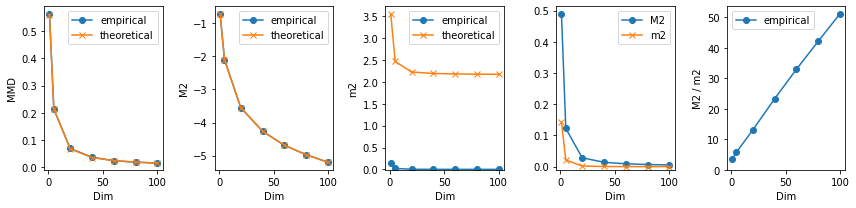

In [516]:
# bandwidth = 2d
plot_moments(res, figsize=(12, 3))

## Check if the asymptotics of var(u) is correct

In [476]:
dims = res["dim"].to_numpy(dtype=np.float32)
lmdas = res["dim"].to_numpy(dtype=np.float32)

var_empirical = (res["M2_empirical"] - res["val_empirical"]**2).to_numpy()
log_var_second_empirical = tf.math.log(var_empirical) - (
    tf.math.log(2.) - 2*dims / lmdas
)

In [477]:
log_var_second_ref = 4 * dims / lmdas**2

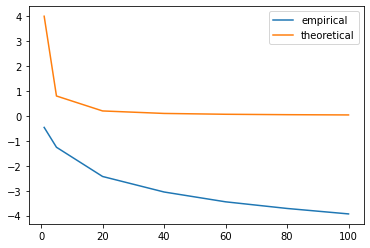

In [478]:
plt.plot(dims, log_var_second_empirical, label="empirical")
plt.plot(dims, log_var_second_ref, label="theoretical")
plt.legend()

In [439]:
log_var_empirical = tf.math.log(var_empirical)
log_var_ref = - 2 * dims / lmdas

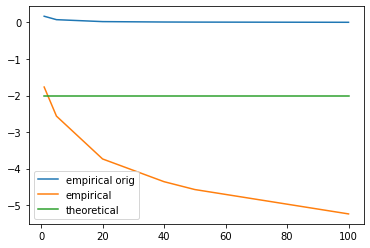

In [440]:
plt.plot(dims, var_empirical, label="empirical orig")
plt.plot(dims, log_var_empirical, label="empirical")
plt.plot(dims, log_var_ref, label="theoretical")
plt.legend()

In [484]:
log_M2_empirical = tf.math.log(res["M2_empirical"])
# log_M2_empirical = tf.math.log((lmdas / (4 + lmdas))**(dims // 2))
# log_M2_empirical = tf.math.log((lmdas / (2 + lmdas))**(dims))
# log_M2_empirical = tf.math.log((lmdas / (3 + lmdas))**(dims // 2) * (lmdas / (1 + lmdas))**(dims // 2))
# log_M2_ref = tf.math.log(2.) - 2. * dims / lmdas + tf.math.log(
#     2 * tf.math.exp(4 * dims / lmdas**2) +
#     2 * tf.math.exp(2 * dims / lmdas**2) -
#     4 * tf.math.exp(5 * dims / (2 * lmdas**2))
# )
log_M2_ref = tf.math.log(
    2 * tf.math.exp(4 * dims / lmdas**2) +
    2 * tf.math.exp(2 * dims / lmdas**2) -
    4 * tf.math.exp(5 * dims / (2 * lmdas**2))
)

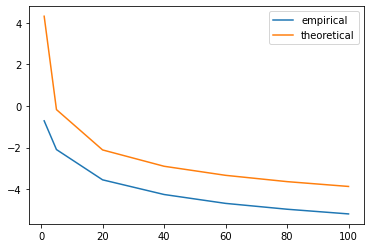

In [485]:
plt.plot(dims, log_M2_empirical, label="empirical")
plt.plot(dims, log_M2_ref, label="theoretical")
plt.legend()

In [451]:
log_val_empirical = tf.math.log(res["val_empirical"])
mu_norm_sq = 4.
log_val_ref = tf.math.log(2.) - dims / lmdas + tf.math.log(mu_norm_sq / ( 2. * (2 + lmdas) ))

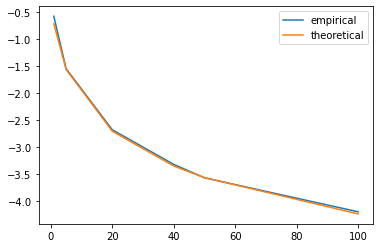

In [452]:
plt.plot(dims, log_val_empirical, label="empirical")
plt.plot(dims, log_val_ref, label="theoretical")
plt.legend()

# Repeated 

In [57]:
nrep = 10
res_rep = repeat_compute_moments(dims, deltas, IMQ, n=4000, nreps=nrep, bandwidth_order=1., verbose=True)

[1 / 10]
dim: 1; delta: 2.0
dim: 5; delta: 2.0
dim: 20; delta: 2.0
dim: 40; delta: 2.0
dim: 50; delta: 2.0
dim: 100; delta: 2.0
[2 / 10]
dim: 1; delta: 2.0
dim: 5; delta: 2.0
dim: 20; delta: 2.0
dim: 40; delta: 2.0
dim: 50; delta: 2.0
dim: 100; delta: 2.0
[3 / 10]
dim: 1; delta: 2.0
dim: 5; delta: 2.0
dim: 20; delta: 2.0
dim: 40; delta: 2.0
dim: 50; delta: 2.0
dim: 100; delta: 2.0
[4 / 10]
dim: 1; delta: 2.0
dim: 5; delta: 2.0
dim: 20; delta: 2.0
dim: 40; delta: 2.0
dim: 50; delta: 2.0
dim: 100; delta: 2.0
[5 / 10]
dim: 1; delta: 2.0
dim: 5; delta: 2.0
dim: 20; delta: 2.0
dim: 40; delta: 2.0
dim: 50; delta: 2.0
dim: 100; delta: 2.0
[6 / 10]
dim: 1; delta: 2.0
dim: 5; delta: 2.0
dim: 20; delta: 2.0
dim: 40; delta: 2.0
dim: 50; delta: 2.0
dim: 100; delta: 2.0
[7 / 10]
dim: 1; delta: 2.0
dim: 5; delta: 2.0
dim: 20; delta: 2.0
dim: 40; delta: 2.0
dim: 50; delta: 2.0
dim: 100; delta: 2.0
[8 / 10]
dim: 1; delta: 2.0
dim: 5; delta: 2.0
dim: 20; delta: 2.0
dim: 40; delta: 2.0
dim: 50; delta: 2

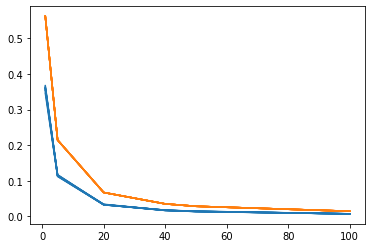

In [75]:
x_vals = np.array([dims]*nrep).reshape((nrep, -1)).T
y_vals_num = np.array(res_rep["val_empirical"]).reshape((nrep, -1)).T
y_vals_the = np.array(res_rep["val_theoretical"]).reshape((nrep, -1)).T

_ = plt.plot(x_vals, y_vals_num, label="numerical", color="C0")
_ = plt.plot(x_vals, y_vals_the, label="theoretical", color="C1")
# plt.plot([dims[0], dims[-1]], [res_numerical[0], res_numerical[-1]], label="ref")
# plt.legend()